In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [2]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/notebooks

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/notebooks


In [3]:
adata = sc.read_h5ad('../eraslan_preprocessed1200_split_deg.h5ad')

In [4]:
def check_difference(adata,  # OOD Adata
                cov_names,
                cov_values: str,
                cov_values_cf: str,):
    adata.X = adata.layers['counts']
    adata.obs['idx'] = [i for i in range(len(adata))]

    true_indices = pd.DataFrame([adata.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    true_idx = list(adata[true_indices].obs['idx'])
    
    source_indices = pd.DataFrame([adata.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_idx = list(adata[source_indices].obs['idx'])
                    
    # true_idx = list(adata[adata.obs[cov_name] == cov_values_cf].obs['idx'])
    # source_idx = list(adata[adata.obs[cov_name] == cov_values].obs['idx'])

    true_adata = adata[adata.obs['idx'].isin(true_idx)].copy()
    source_adata = adata[adata.obs['idx'].isin(source_idx)].copy()

    # sc.pp.normalize_total(true_adata)
    true_x_count = torch.tensor(true_adata.X.toarray())
    # sc.pp.normalize_total(source_adata)
    cf_x_count = torch.tensor(source_adata.X.toarray())

    x_true = true_x_count
    x_ctrl = cf_x_count

    x_true = np.log1p(x_true)
    x_ctrl = np.log1p(x_ctrl)
    return x_ctrl, x_true

In [5]:
def check_difference_no_reference(adata,  # OOD Adata
                cov_names,
                cov_values_cf: str,):
    adata.X = adata.layers['counts']
    adata.obs['idx'] = [i for i in range(len(adata))]

    true_indices = pd.DataFrame([adata.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    true_idx = list(adata[true_indices].obs['idx'])
    
    source_indices = pd.DataFrame([adata.obs[cov_name] != cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_idx = list(adata[source_indices].obs['idx'])
                    
    # true_idx = list(adata[adata.obs[cov_name] == cov_values_cf].obs['idx'])
    # source_idx = list(adata[adata.obs[cov_name] == cov_values].obs['idx'])

    true_adata = adata[adata.obs['idx'].isin(true_idx)].copy()
    source_adata = adata[adata.obs['idx'].isin(source_idx)].copy()

    # sc.pp.normalize_total(true_adata)
    true_x_count = torch.tensor(true_adata.X.toarray())
    # sc.pp.normalize_total(source_adata)
    cf_x_count = torch.tensor(source_adata.X.toarray())

    x_true = true_x_count
    x_ctrl = cf_x_count

    x_true = np.log1p(x_true)
    x_ctrl = np.log1p(x_ctrl)
    return x_ctrl, x_true

In [16]:
bisex_ct = [ct for ct in adata.obs['Broad cell type'].unique() if len(adata[adata.obs['Broad cell type'] == ct].obs['sex'].unique()) == 2]

adata.X = adata.layers['counts']
sc.pp.log1p(adata)
adata.obs['cov_sex'] = adata.obs['Broad cell type'].astype(str) + '_' + adata.obs.sex.astype(str)
mt = [gene for gene in adata.var['gene_name'] if gene.startswith('MT-')]
rp = [gene for gene in adata.var['gene_name'] if (gene.startswith('RPL') or gene.startswith('RPS'))]
remove = mt + rp
adata_ = adata[:, ~adata.var['gene_name'].isin(remove)]

adata_ = adata_[adata_.obs['Broad cell type'].isin(bisex_ct)]

groupby='cov_sex'
control_group='female'
covariate='Broad cell type'
key_added="rank_genes_groups_sex"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
cov_categories = adata_.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    # control_group_cov = "_".join([cov_cat, control_group])
    # if control_group_cov not in adata_.obs[groupby].values:
    #     continue
    # subset adata to cells belonging to a covariate category
    adata_cov = adata_[adata_.obs[covariate] == cov_cat]
    
    # compute DEGs
    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        # reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )
    # scanpy.get.rank_genes_groups_df(adata, group, *, key=‘rank_genes_groups’, pval_cutoff=None, log2fc_min=None, log2fc_max=None, gene_symbols=None)

    # add entries to dictionary of gene sets
    # de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
    # de_pvals = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["pvals"])
    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns
    
    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['logfoldchanges']
        
        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)
        
        gene_dict[group] = de_genes[group].tolist()
        # gene_dict[group] = de_pvals[group].tolist()

adata_.uns[key_added] = gene_dict
adata.uns[key_added] = adata_.uns[key_added]
adata.X = adata.layers['counts']

Myocyte (sk. muscle, cytoplasmic)
Myocyte (NMJ-rich)
Endothelial cell (vascular)
Myocyte (sk. muscle)
Fibroblast
Pericyte/SMC
Immune (DC/macrophage)
Adipocyte
Schwann cell
Satellite cell
Endothelial cell (lymphatic)
Immune (T cell)
Immune (NK cell)
Immune (mast cell)
Epithelial cell (luminal)
Epithelial cell (basal)
Immune (B cell)
Neuroendocrine
Myocyte (smooth muscle)
Neuronal
ICCs
Myocyte (cardiac, cytoplasmic)
Myocyte (cardiac)
Epithelial cell (alveolar type II)
Immune (alveolar macrophage)
Epithelial cell (ciliated)
Epithelial cell (alveolar type I)
Epithelial cell (club)
Sweat gland cell
Unknown
Epithelial cell (basal keratinocyte)
Sebaceous gland cell
Epithelial cell (suprabasal keratinocyte)
Melanocyte


In [17]:
adata.uns[key_added].keys()

dict_keys(['Myocyte (sk. muscle, cytoplasmic)_female', 'Myocyte (sk. muscle, cytoplasmic)_male', 'Myocyte (NMJ-rich)_female', 'Myocyte (NMJ-rich)_male', 'Endothelial cell (vascular)_female', 'Endothelial cell (vascular)_male', 'Myocyte (sk. muscle)_female', 'Myocyte (sk. muscle)_male', 'Fibroblast_female', 'Fibroblast_male', 'Pericyte/SMC_female', 'Pericyte/SMC_male', 'Immune (DC/macrophage)_female', 'Immune (DC/macrophage)_male', 'Adipocyte_female', 'Adipocyte_male', 'Schwann cell_female', 'Schwann cell_male', 'Satellite cell_female', 'Satellite cell_male', 'Endothelial cell (lymphatic)_female', 'Endothelial cell (lymphatic)_male', 'Immune (T cell)_female', 'Immune (T cell)_male', 'Immune (NK cell)_female', 'Immune (NK cell)_male', 'Immune (mast cell)_female', 'Immune (mast cell)_male', 'Epithelial cell (luminal)_female', 'Epithelial cell (luminal)_male', 'Epithelial cell (basal)_female', 'Epithelial cell (basal)_male', 'Immune (B cell)_female', 'Immune (B cell)_male', 'Neuroendocrine

In [18]:
adata.uns[key_added]['Myocyte (sk. muscle, cytoplasmic)_female']

['C8orf22',
 'ANGPTL4',
 'ACTC1',
 'LPL',
 'MYH1',
 'RP11-532N4.2',
 'AC016723.4',
 'CSRP3',
 'MYF6',
 'MT1E',
 'CKB',
 'CHAC1',
 'TNNI2',
 'FTL',
 'LMCD1',
 'CD36',
 'ERRFI1',
 'MT1A',
 'RNF19B',
 'COX7C',
 'TNNT3',
 'MYH2',
 'TNNC2',
 'IFITM3',
 'ACTG1',
 'S100A6',
 'TMSB4X',
 'ZNF90',
 'TXNRD1',
 'PGAM2',
 'XIRP2',
 'MYLPF',
 'APOO',
 'EEF1A2',
 'CKMT2',
 'ANKRD2',
 'G0S2',
 'BAIAP2L1',
 'MRPL41',
 'FTH1',
 'MT2A',
 'ACTB',
 'CTNNA3',
 'NEXN',
 'TPM1',
 'AC072062.1',
 'HSPB1',
 'KLHL41',
 'UQCR10',
 'SEPW1',
 'COX6B1',
 'UQCRH',
 'MYL2',
 'NDUFB3',
 'MYL3',
 'CKM',
 'CRYAB',
 'GLUL',
 'PDLIM3',
 'GAPDH',
 'TRDN',
 'SLC25A4',
 'CYCS',
 'TPT1',
 'TNNI1',
 'COX4I1',
 'SLC26A3',
 'XPO5',
 'RASGEF1B',
 'COX5B',
 'RP11-451G4.2',
 'MYL12A',
 'SLN',
 'CST3',
 'CMYA5',
 'CHCHD10',
 'ATP5J',
 'ACTA1',
 'ALDOA',
 'FLNC',
 'TNNT1',
 'DES',
 'TPM3',
 'NEB',
 'TTN']

In [19]:
from scipy.stats import pearsonr

difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    cell_type_to_check = key.split('_')[0]
    cov_names = ['sex']
    cov_values = ['male' if key.split('_')[1] == 'female' else 'female']
    cov_values_cf = [key.split('_')[1]]
    if len(degs) < 2:
        continue
    x_ctrl, x_true = check_difference(
                adata[adata.obs['Broad cell type'] == cell_type_to_check],
                cov_names,
                cov_values,
                cov_values_cf,)
    degs = np.where(np.isin(adata.var_names, degs))[0]
    x_true_deg = x_true[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]
    
    difference_dict['Group'].append(key)
    difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
    difference_dict['n_DEGs'].append(len(degs))

In [20]:
difference_dict_sex = difference_dict.copy()

In [21]:
difference_df_sex = pd.DataFrame(difference_dict_sex)
difference_df_sex

,Group,Correlation with control,n_DEGs
0,"Myocyte (sk. muscle, cytoplasmic)_female",0.78,85
1,"Myocyte (sk. muscle, cytoplasmic)_male",0.78,85
2,Myocyte (NMJ-rich)_female,0.60,12
3,Myocyte (NMJ-rich)_male,0.60,12
4,Endothelial cell (vascular)_female,0.92,138
5,Endothelial cell (vascular)_male,0.92,138
6,Myocyte (sk. muscle)_female,0.81,155
7,Myocyte (sk. muscle)_male,0.81,155
8,Fibroblast_female,0.89,195
9,Fibroblast_male,0.89,195


In [22]:
difference_sex_ct = difference_df_sex[::2].reset_index(drop=True)
difference_sex_ct.Group = difference_sex_ct.Group.apply(lambda x: x.split('_')[0])
difference_sex_ct

,Group,Correlation with control,n_DEGs
0,"Myocyte (sk. muscle, cytoplasmic)",0.78,85
1,Myocyte (NMJ-rich),0.60,12
2,Endothelial cell (vascular),0.92,138
3,Myocyte (sk. muscle),0.81,155
4,Fibroblast,0.89,195
5,Pericyte/SMC,0.78,47
6,Immune (DC/macrophage),0.88,114
7,Adipocyte,0.61,92
8,Schwann cell,0.88,30
9,Endothelial cell (lymphatic),0.95,81


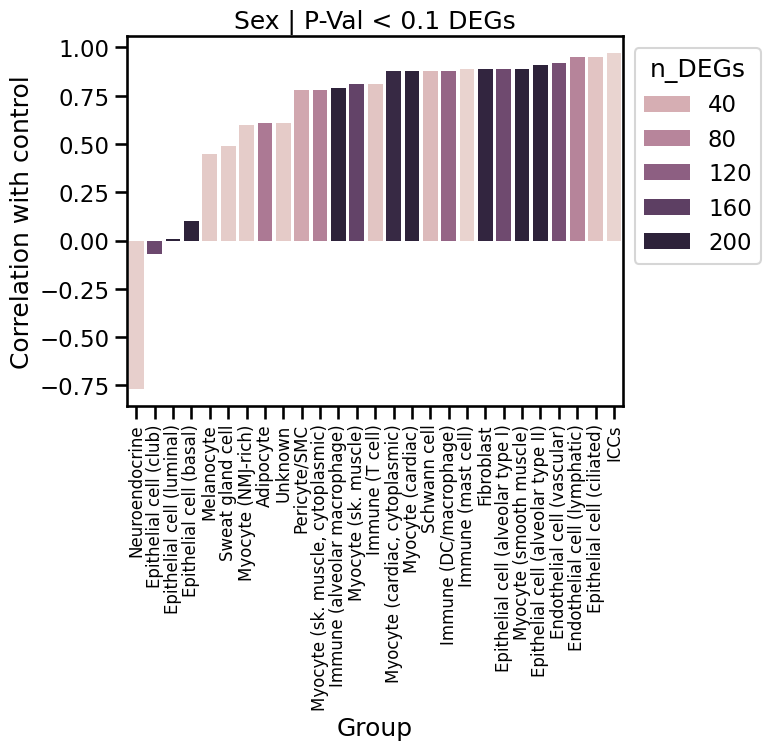

In [23]:
ax = sns.barplot(difference_sex_ct.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Sex | P-Val < 0.1 DEGs')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [24]:
from scipy.stats import pearsonr

difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    if ('Epithelial' in key) and (difference_df_sex[difference_df_sex['Group'] == key]['Correlation with control'] < 0.5).values:
        cell_type_to_check = key.split('_')[0]
        cov_names = ['sex']
        cov_values = ['male' if key.split('_')[1] == 'female' else 'female']
        cov_values_cf = [key.split('_')[1]]
        if len(degs) < 2:
            continue
        x_ctrl, x_true = check_difference(
                    adata[adata.obs['Broad cell type'] == cell_type_to_check],
                    cov_names,
                    cov_values,
                    cov_values_cf,)
        degs = np.where(np.isin(adata.var_names, degs[:50]))[0]
        x_true_deg = x_true[:, degs]
        x_ctrl_deg = x_ctrl[:, degs]

        r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
        r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]

        difference_dict['Group'].append(key)
        difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
        difference_dict['n_DEGs'].append(len(degs))
difference_pd = pd.DataFrame(difference_dict)

difference_sex_Epithelial = difference_pd[::2].reset_index(drop=True)
difference_sex_Epithelial.Group = difference_sex_Epithelial.Group.apply(lambda x: x.split('_')[0])
difference_sex_Epithelial

,Group,Correlation with control,n_DEGs
0,Epithelial cell (luminal),-0.27,50
1,Epithelial cell (basal),-0.42,50
2,Epithelial cell (club),-0.14,50


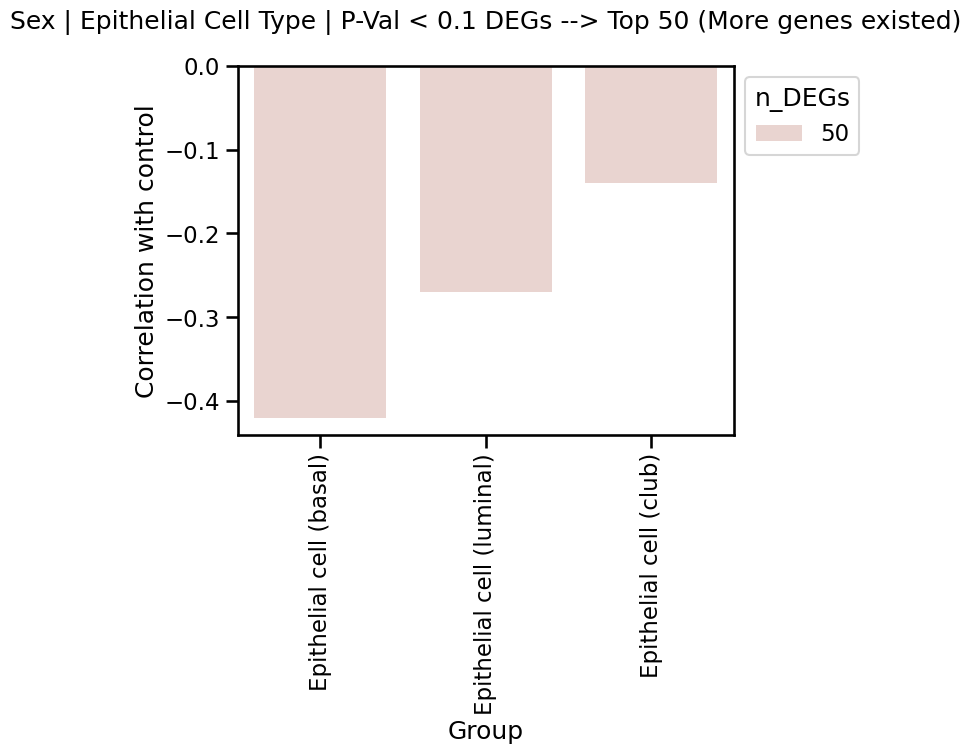

In [25]:
ax = sns.barplot(difference_sex_Epithelial.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Sex | Epithelial Cell Type | P-Val < 0.1 DEGs --> Top 50 (More genes existed)\n')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

In [26]:
adata.X = adata.layers['counts']
sc.pp.log1p(adata)
adata.obs['cov_tissue'] = adata.obs['Broad cell type'].astype(str) + '_' + adata.obs.tissue.astype(str)
mt = [gene for gene in adata.var['gene_name'] if gene.startswith('MT-')]
rp = [gene for gene in adata.var['gene_name'] if (gene.startswith('RPL') or gene.startswith('RPS'))]
remove = mt + rp
adata_ = adata[:, ~adata.var['gene_name'].isin(remove)]

# adata_ = adata_[adata_.obs['Broad cell type'].isin(bisex_ct)]

groupby='cov_tissue'
covariate='Broad cell type'
key_added="rank_genes_groups_tissue"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
cov_categories = adata_.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # subset adata to cells belonging to a covariate category
    adata_cov = adata_[adata_.obs[covariate] == cov_cat]
    if len(adata_cov.obs['tissue'].unique()) < 2:
        continue
    # compute DEGs
    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        # reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )
    # scanpy.get.rank_genes_groups_df(adata, group, *, key=‘rank_genes_groups’, pval_cutoff=None, log2fc_min=None, log2fc_max=None, gene_symbols=None)

    # add entries to dictionary of gene sets
    # de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
    # de_pvals = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["pvals"])
    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns
    
    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['logfoldchanges']
        
        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)
        
        gene_dict[group] = de_genes[group].tolist()

adata_.uns[key_added] = gene_dict
adata.uns[key_added] = adata_.uns[key_added]
adata.X = adata.layers['counts']

Myocyte (sk. muscle, cytoplasmic)
Myocyte (NMJ-rich)
Endothelial cell (vascular)
Myocyte (sk. muscle)
Fibroblast
Pericyte/SMC
Immune (DC/macrophage)
Adipocyte
Schwann cell
Satellite cell
Endothelial cell (lymphatic)
Immune (T cell)
Immune (NK cell)
Immune (mast cell)
Epithelial cell (luminal)
Myoepithelial (basal)
Epithelial cell (squamous)
Epithelial cell (suprabasal)
Myofibroblast
Epithelial cell (basal)
Mucous cell
Immune (B cell)
Immune (DC)
Neuroendocrine
Myocyte (smooth muscle)
Neuronal
ICCs
Myocyte (cardiac, cytoplasmic)
Myocyte (cardiac)
Epithelial cell (alveolar type II)
Immune (alveolar macrophage)
Epithelial cell (ciliated)
Epithelial cell (alveolar type I)
Epithelial cell (club)
Epithelial cell (Hillock)
Sweat gland cell
Epithelial cell (cornified keratinocyte)
Unknown
Epithelial cell (basal keratinocyte)
Sebaceous gland cell
Epithelial cell (mature keratinocyte)
Epithelial cell (suprabasal keratinocyte)
Melanocyte
Immune (Langerhans)


In [27]:
from scipy.stats import pearsonr

difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    cell_type_to_check = key.split('_')[0]
    cov_names = ['tissue']
    cov_values_cf = [key.split('_')[1]]
    if len(degs) < 2:
        continue
    x_ctrl, x_true = check_difference_no_reference(
                adata[adata.obs['Broad cell type'] == cell_type_to_check],
                cov_names,
                cov_values_cf,)
    degs = np.where(np.isin(adata.var_names, degs))[0]
    x_true_deg = x_true[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]
    
    difference_dict['Group'].append(key)
    difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
    difference_dict['n_DEGs'].append(len(degs))

In [28]:
difference_dict_tissue = difference_dict.copy()
difference_dict_tissue = pd.DataFrame(difference_dict_tissue)
difference_dict_tissue

,Group,Correlation with control,n_DEGs
0,Endothelial cell (vascular)_anterior wall of l...,0.80,182
1,Endothelial cell (vascular)_breast,0.70,77
2,Endothelial cell (vascular)_esophagus muscular...,0.74,156
3,Endothelial cell (vascular)_gastrocnemius,0.82,92
4,Endothelial cell (vascular)_lingula of left lung,0.63,200
...,...,...,...
71,Neuroendocrine_prostate gland,-0.77,9
72,Myocyte (smooth muscle)_esophagus muscularis m...,0.78,200
73,Myocyte (smooth muscle)_prostate gland,0.78,200
74,Epithelial cell (club)_lingula of left lung,-0.01,200


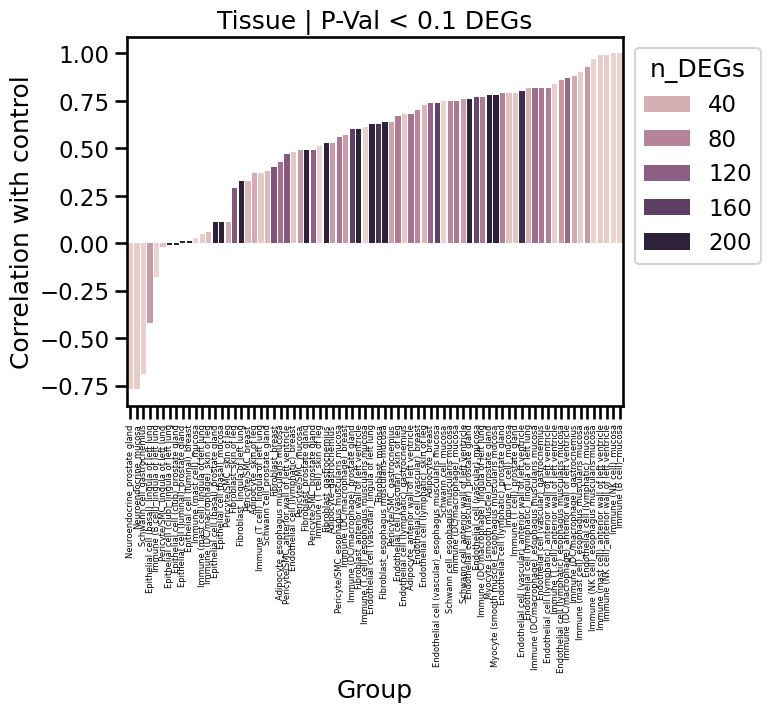

In [29]:
ax = sns.barplot(difference_dict_tissue.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Tissue | P-Val < 0.1 DEGs')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, fontsize=6)
plt.show()

In [30]:
difference_dict_tissue[difference_dict_tissue['Correlation with control'] < 0.1]

,Group,Correlation with control,n_DEGs
20,Pericyte/SMC_lingula of left lung,-0.02,21
31,Immune (DC/macrophage)_skin of leg,0.06,23
39,Schwann cell_gastrocnemius,-0.69,6
61,Immune (mast cell)_lingula of left lung,0.05,8
62,Immune (mast cell)_mucosa,0.03,3
63,Epithelial cell (luminal)_breast,0.01,200
64,Epithelial cell (luminal)_prostate gland,0.01,200
65,Epithelial cell (basal)_lingula of left lung,-0.42,60
68,Immune (B cell)_lingula of left lung,-0.18,4
70,Neuroendocrine_mucosa,-0.77,9


In [31]:
from scipy.stats import pearsonr

difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    if ('Epithelial' in key) and (difference_dict_tissue[difference_dict_tissue['Group'] == key]['Correlation with control'] < 0.5).values:
        cell_type_to_check = key.split('_')[0]
        cov_names = ['tissue']
        cov_values_cf = [key.split('_')[1]]
        if len(degs) < 2:
            continue
        x_ctrl, x_true = check_difference_no_reference(
                    adata[adata.obs['Broad cell type'] == cell_type_to_check],
                    cov_names,
                    cov_values_cf,)
        degs = np.where(np.isin(adata.var_names, degs[:50]))[0]
        x_true_deg = x_true[:, degs]
        x_ctrl_deg = x_ctrl[:, degs]

        r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
        r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]

        difference_dict['Group'].append(key)
        difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
        difference_dict['n_DEGs'].append(len(degs))
difference_pd = pd.DataFrame(difference_dict)

difference_tissue_Epithelial = difference_pd
difference_tissue_Epithelial

,Group,Correlation with control,n_DEGs
0,Epithelial cell (luminal)_breast,-0.32,50
1,Epithelial cell (luminal)_prostate gland,-0.32,50
2,Epithelial cell (basal)_lingula of left lung,-0.47,50
3,Epithelial cell (basal)_mucosa,-0.44,50
4,Epithelial cell (basal)_prostate gland,-0.42,50
5,Epithelial cell (club)_lingula of left lung,-0.34,50
6,Epithelial cell (club)_prostate gland,-0.34,50


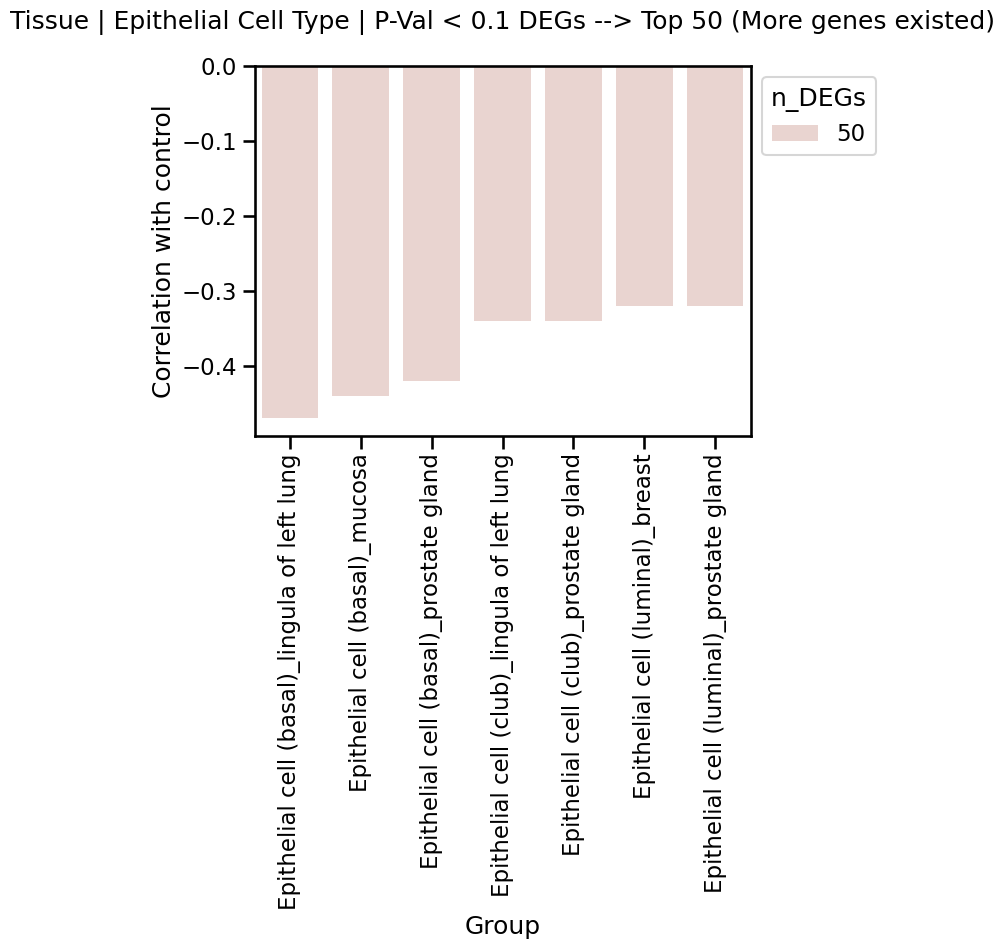

In [32]:
ax = sns.barplot(difference_tissue_Epithelial.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Tissue | Epithelial Cell Type | P-Val < 0.1 DEGs --> Top 50 (More genes existed)\n')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

In [33]:
adata.X = adata.layers['counts']
sc.pp.log1p(adata)
adata.obs['cov_age'] = adata.obs['Broad cell type'].astype(str) + '_' + adata.obs.Age_bin.astype(str)
mt = [gene for gene in adata.var['gene_name'] if gene.startswith('MT-')]
rp = [gene for gene in adata.var['gene_name'] if (gene.startswith('RPL') or gene.startswith('RPS'))]
remove = mt + rp
adata_ = adata[:, ~adata.var['gene_name'].isin(remove)]

# adata_ = adata_[adata_.obs['Broad cell type'].isin(bisex_ct)]

groupby='cov_age'
covariate='Broad cell type'
key_added="rank_genes_groups_age"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
cov_categories = adata_.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # subset adata to cells belonging to a covariate category
    adata_cov = adata_[adata_.obs[covariate] == cov_cat]
    if len(adata_cov.obs['Age_bin'].unique()) < 2:
        continue
    age_groups = adata_cov.obs['Age_bin'].unique()
    for age_group in age_groups:
        if len(adata_cov[adata_cov.obs['Age_bin'] == age_group]) < 2:
            adata_cov = adata_cov[adata_cov.obs['Age_bin'] != age_group]
    # compute DEGs
    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        # reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )
    # scanpy.get.rank_genes_groups_df(adata, group, *, key=‘rank_genes_groups’, pval_cutoff=None, log2fc_min=None, log2fc_max=None, gene_symbols=None)

    # add entries to dictionary of gene sets
    # de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
    # de_pvals = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["pvals"])
    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns
    
    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['logfoldchanges']
        
        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)
        
        gene_dict[group] = de_genes[group].tolist()

adata_.uns[key_added] = gene_dict
adata.uns[key_added] = adata_.uns[key_added]
adata.X = adata.layers['counts']

Myocyte (sk. muscle, cytoplasmic)
Myocyte (NMJ-rich)
Endothelial cell (vascular)
Myocyte (sk. muscle)
Fibroblast
Pericyte/SMC
Immune (DC/macrophage)
Adipocyte
Schwann cell
Satellite cell
Endothelial cell (lymphatic)
Immune (T cell)
Immune (NK cell)
Immune (mast cell)
Epithelial cell (luminal)
Myoepithelial (basal)
Epithelial cell (squamous)
Epithelial cell (suprabasal)
Myofibroblast
Epithelial cell (basal)
Mucous cell
Immune (B cell)
Immune (DC)
Neuroendocrine
Myocyte (smooth muscle)
Neuronal
ICCs
Myocyte (cardiac, cytoplasmic)
Myocyte (cardiac)
Epithelial cell (alveolar type II)
Immune (alveolar macrophage)
Epithelial cell (ciliated)
Epithelial cell (alveolar type I)
Epithelial cell (club)
Epithelial cell (Hillock)
Sweat gland cell
Epithelial cell (cornified keratinocyte)
Unknown
Epithelial cell (basal keratinocyte)
Sebaceous gland cell
Epithelial cell (mature keratinocyte)
Epithelial cell (suprabasal keratinocyte)
Melanocyte
Immune (Langerhans)


In [34]:
from scipy.stats import pearsonr

difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    cell_type_to_check = key.split('_')[0]
    cov_names = ['Age_bin']
    cov_values_cf = [key.split('_')[1]]
    if len(degs) < 2:
        continue
    x_ctrl, x_true = check_difference_no_reference(
                adata[adata.obs['Broad cell type'] == cell_type_to_check],
                cov_names,
                cov_values_cf,)
    degs = np.where(np.isin(adata.var_names, degs))[0]
    x_true_deg = x_true[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]
    
    difference_dict['Group'].append(key)
    difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
    difference_dict['n_DEGs'].append(len(degs))

In [35]:
difference_dict_age = difference_dict.copy()
difference_dict_age = pd.DataFrame(difference_dict_age)
difference_dict_age

,Group,Correlation with control,n_DEGs
0,"Myocyte (sk. muscle, cytoplasmic)_41-50",0.76,85
1,"Myocyte (sk. muscle, cytoplasmic)_51-60",0.85,91
2,"Myocyte (sk. muscle, cytoplasmic)_61-70",0.53,82
3,Myocyte (NMJ-rich)_41-50,0.60,12
4,Myocyte (NMJ-rich)_51-60,0.62,12
...,...,...,...
99,Sweat gland cell_51-60,0.35,21
100,Unknown_21-40,0.54,11
101,Unknown_51-60,0.54,11
102,Melanocyte_21-40,0.47,14


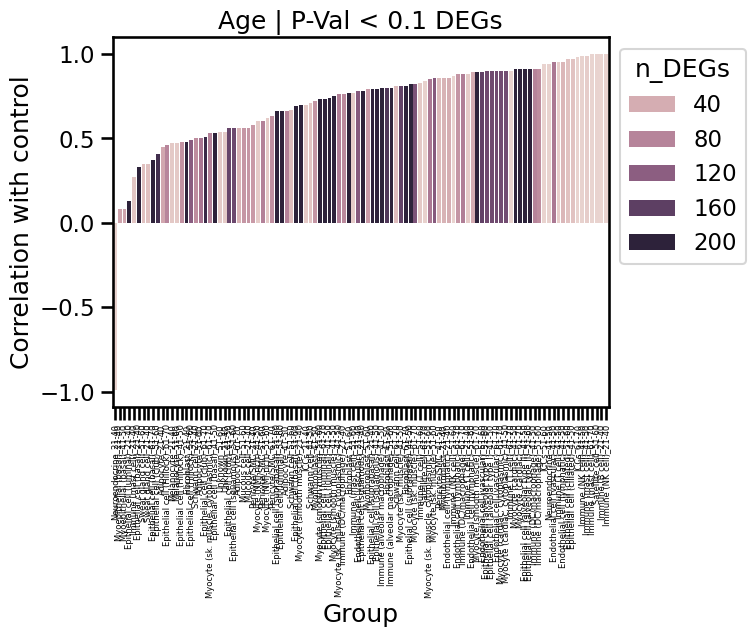

In [36]:
ax = sns.barplot(difference_dict_age.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Age | P-Val < 0.1 DEGs')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, fontsize=6)
plt.show()

In [37]:
difference_dict_age[difference_dict_age['Correlation with control'] < 0.5]

,Group,Correlation with control,n_DEGs
12,Fibroblast_21-40,0.48,198
24,Adipocyte_21-40,0.45,45
45,Immune (mast cell)_21-40,0.27,16
49,Epithelial cell (luminal)_21-40,0.13,200
53,Myoepithelial (basal)_21-40,0.08,49
54,Myoepithelial (basal)_41-50,0.08,49
64,Epithelial cell (basal)_21-40,0.33,200
67,Epithelial cell (basal)_61-70,0.37,200
71,Neuroendocrine_21-40,-0.99,5
93,Epithelial cell (club)_51-60,0.41,182


In [38]:
from scipy.stats import pearsonr

difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    if ('Epithelial' in key) and (difference_dict_age[difference_dict_age['Group'] == key]['Correlation with control'] < 0.5).values:
        cell_type_to_check = key.split('_')[0]
        cov_names = ['Age_bin']
        cov_values_cf = [key.split('_')[1]]
        if len(degs) < 2:
            continue
        x_ctrl, x_true = check_difference_no_reference(
                    adata[adata.obs['Broad cell type'] == cell_type_to_check],
                    cov_names,
                    cov_values_cf,)
        degs = np.where(np.isin(adata.var_names, degs[:50]))[0]
        x_true_deg = x_true[:, degs]
        x_ctrl_deg = x_ctrl[:, degs]

        r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
        r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]

        difference_dict['Group'].append(key)
        difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
        difference_dict['n_DEGs'].append(len(degs))
difference_pd = pd.DataFrame(difference_dict)

difference_age_Epithelial = difference_pd
difference_age_Epithelial

,Group,Correlation with control,n_DEGs
0,Epithelial cell (luminal)_21-40,0.46,50
1,Epithelial cell (basal)_21-40,-0.65,50
2,Epithelial cell (basal)_61-70,0.47,50
3,Epithelial cell (club)_51-60,0.14,50
4,Epithelial cell (Hillock)_41-50,-0.05,50
5,Epithelial cell (Hillock)_51-60,-0.25,50
6,Epithelial cell (Hillock)_61-70,-0.03,50


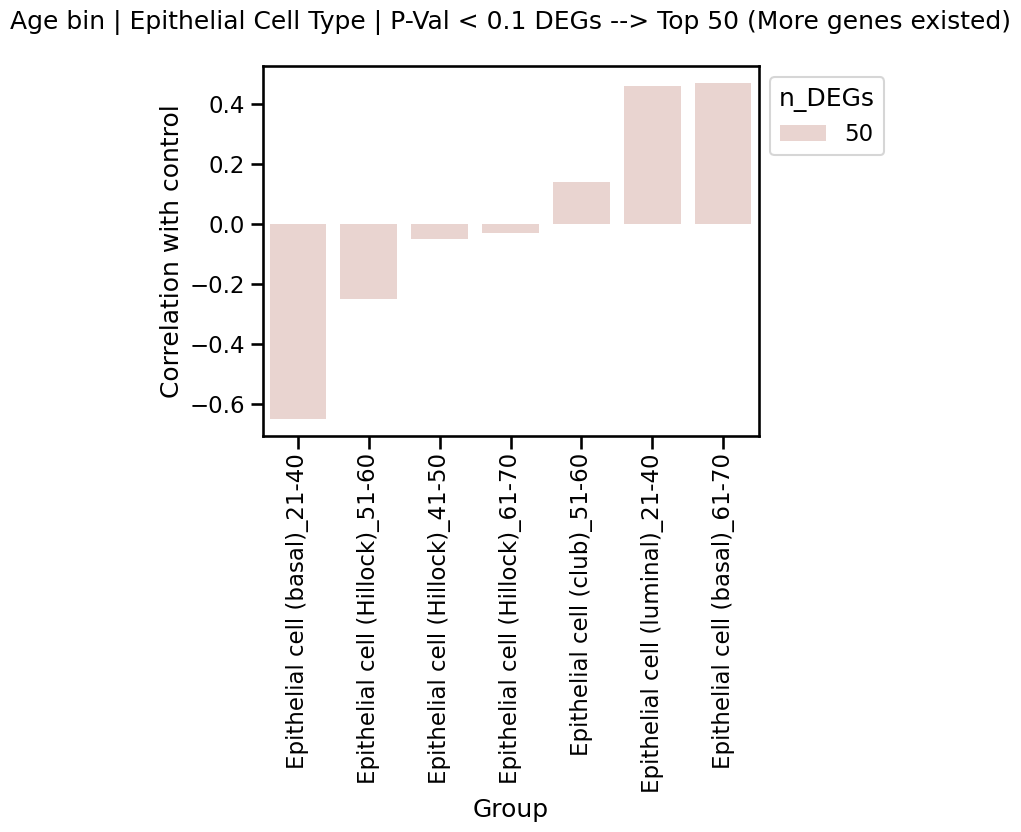

In [39]:
ax = sns.barplot(difference_age_Epithelial.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Age bin | Epithelial Cell Type | P-Val < 0.1 DEGs --> Top 50 (More genes existed)\n')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

In [40]:
adata.uns.keys()

dict_keys(['Broad cell type (numbers)_colors', 'Broad cell type_colors', 'Broad cell type_sizes', 'Tissue composition_colors', '_scvi_manager_uuid', '_scvi_uuid', 'citation', "dendrogram_['Broad cell type']", 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'prep_colors', 'rank_genes_groups_ood', 'rank_genes_groups_ood_ct', 'schema_reference', 'schema_version', 'title', 'umap', 'rank_genes_groups_sex', 'rank_genes_groups_tissue', 'rank_genes_groups_age'])

In [ ]:
adata.write('../eraslan_preprocessed1200_split_deg.h5ad')